In [1]:
import numpy as np
import pandas as pd
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import xarray as xr
import math

sys.path.append('..//')
from utils import translate_grid_to_origin, get_grid_angle, rotate_grid

In [2]:
particle_folders =[r"~//parcels_toolbox//02_output//artful_01_diff.zarr",
                  r"~//parcels_toolbox//02_output//artful_02_diff.zarr",
                  r"~//parcels_toolbox//02_output//artful_03_diff.zarr"]

plot_dates = [np.datetime64('2023-09-12 10:00:00'),
              np.datetime64('2023-11-08 11:00:00'),
              np.datetime64('2024-05-01 10:00:00')]

measure_file_paths = [ r".//coord_sampling//measures_20230912.txt",
                       r".//coord_sampling//measures_20231108.txt",
                       r".//coord_sampling//measures_20240501.txt"]

In [114]:
rotate = True

i_scenario = 2

particle_folder = particle_folders[i_scenario]
plot_date = plot_dates[i_scenario]
measure_file_path = measure_file_paths[i_scenario]

output_folder_path = r'.//figures'

In [115]:
from zoneinfo import ZoneInfo 
dt_naive = plot_date.astype('datetime64').astype(datetime)
dt_utc = dt_naive.replace(tzinfo=ZoneInfo("UTC"))
dt_bern = dt_utc.astimezone(ZoneInfo("Europe/Zurich"))


In [116]:
str_Bern_plot_date = dt_bern.strftime('%Y-%m-%d %H:%M:%S %Z')
print(str_Bern_plot_date)

2024-05-01 12:00:00 CEST


# Get particles

In [117]:
xr_particules = xr.open_zarr(particle_folder) # obs= time index (0=the moment the particule is seeded), trajectory= particle

In [118]:
arr_time = xr_particules.time.values.flatten()
df_time = pd.Series(arr_time)
df_time = df_time.dropna().drop_duplicates()

In [119]:
df_time

0     2024-04-21 12:00:00
1     2024-04-21 13:00:00
2     2024-04-21 14:00:00
3     2024-04-21 15:00:00
4     2024-04-21 16:00:00
              ...        
239   2024-05-01 11:00:00
240   2024-05-01 12:00:00
241   2024-05-01 13:00:00
242   2024-05-01 14:00:00
243   2024-05-01 15:00:00
Length: 244, dtype: datetime64[ns]

In [120]:
xr_particules['age'] = (xr_particules['time'] - xr_particules['time'].isel(obs=0)).dt.total_seconds() / 86400

### Select plot date 

In [121]:
snapshot = xr_particules.where(xr_particules['time']==plot_date)
mask_snapshot = ~np.isnan(snapshot.lon.values)

In [122]:
x_part, y_part, z_part, age_part = snapshot["lon"].values[mask_snapshot], snapshot["lat"].values[mask_snapshot], snapshot["z"].values[mask_snapshot], snapshot["age"].values[mask_snapshot]

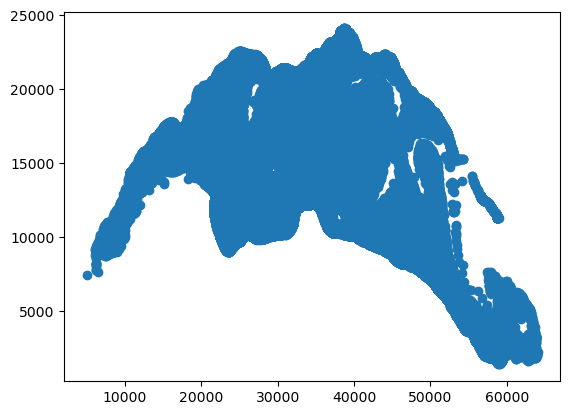

In [123]:
plt.scatter(x_part, y_part)

## Convert particles coordinates to CH1903

In [124]:
# point of origin in swiss grid 
X0_SG = 500000
Y0_SG = 116500

# second point for tilted grid
X1_SG = 563000
Y1_SG = 138700

angle = get_grid_angle(X0_SG, Y0_SG, X1_SG, Y1_SG)

In [125]:
# XY on swiss grid 
x_sg = x_part + X0_SG
y_sg = y_part + Y0_SG

In [126]:
if rotate:
    x_part, y_part = rotate_grid(x_sg, y_sg, X0_SG, Y0_SG, angle)

### Get location of measure points

In [127]:
meas_coordinates = pd.read_csv(measure_file_path, delimiter=';', dtype=None, names=["x", "y", "label"], encoding='utf-8')

### Select particles close to the measure points

In [128]:
buffer_factor = 4

In [129]:
max_distance_from_location = 50 * buffer_factor # [m]

In [130]:
def select_particules_from_distance(x_particules, y_particules, point_location, max_distance_from_point):
    # Calculate distances using vectorized operations
    distances = np.sqrt((x_particules - point_location['x'])**2 + (y_particules - point_location['y'])**2)
    
    # Select indices where distance is less than max_distance_from_location
    sel_i_particules = np.where(distances < max_distance_from_point)[0]
    
    # Convert to list if needed
    return list(sel_i_particules)

In [131]:
i_sel_part_per_point = []
for index, row in meas_coordinates.iterrows():
    i_selected_particules = select_particules_from_distance(x_part, y_part, row, max_distance_from_location)
    i_sel_part_per_point.append(i_selected_particules)

### Concentration at location

In [132]:
conc_init = 2000 / buffer_factor # particules / cellule

In [133]:
concentrations = []
for points in i_sel_part_per_point:
    concentrations.append(len(points) / conc_init)

In [134]:
meas_coordinates['simulated_concentration'] = concentrations
meas_coordinates.to_csv(rf'.//csv//Artful0{i_scenario+1}_concentrations_r{max_distance_from_location}m.csv')

### Age of selected particles

/tmp/ipykernel_1868098/3684341280.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(age_part[i_sel_part_per_point[i_point]], color='blue')


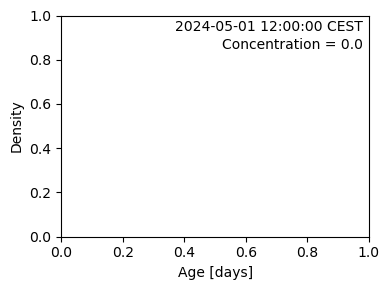

In [135]:
for i_point in range(len(i_sel_part_per_point)):
    plt.close('all')
    fig = plt.figure(figsize=(4, 3))
    sns.kdeplot(age_part[i_sel_part_per_point[i_point]], color='blue')
    
    plt.text(0.98, 0.98, f'{str_Bern_plot_date}', transform=plt.gca().transAxes, ha='right', va='top')
    plt.text(0.98, 0.90, f'Concentration = {concentrations[i_point]}', transform=plt.gca().transAxes, ha='right', va='top')
    plt.xlabel('Age [days]')
    plt.ylabel('Density')
    plt.tight_layout()
    fig.savefig(rf'.//figures//age//Artful0{i_scenario+1}_point{i_point}_r{max_distance_from_location}m.png')